In [1]:
!pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification/

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification/versions/
License(s): ODbL-1.0
100% 735M/736M [00:38<00:00, 16.8MB/s]
100% 736M/736M [00:38<00:00, 19.8MB/s]


**# Data Preprocessing Dan Data Exploration**

In [6]:
import zipfile

with zipfile.ZipFile('eye-diseases-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('eye-diseases-classification')

Class: diabetic_retinopathy - Jumlah Sampel: 1098
-----------------------------------------------------


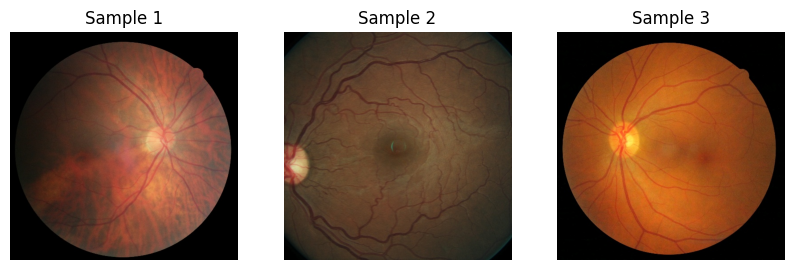



Class: glaucoma - Jumlah Sampel: 1007
-----------------------------------------------------


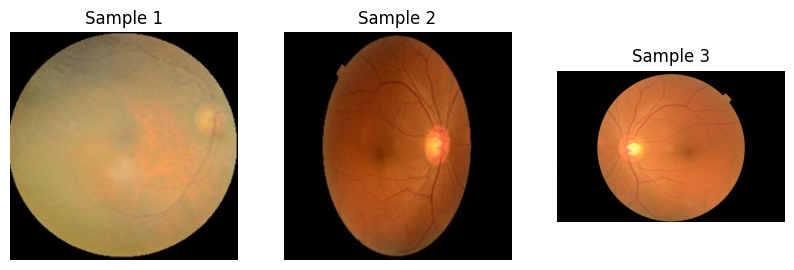



Class: normal - Jumlah Sampel: 1074
-----------------------------------------------------


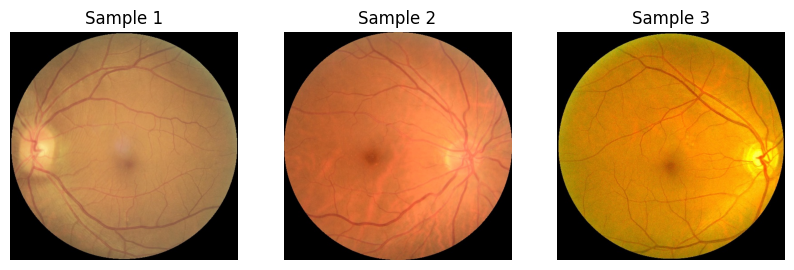



Class: cataract - Jumlah Sampel: 1038
-----------------------------------------------------


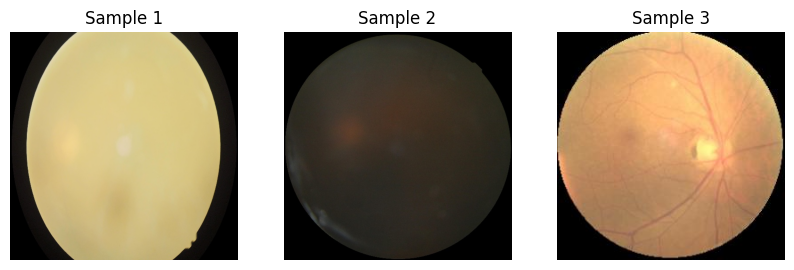

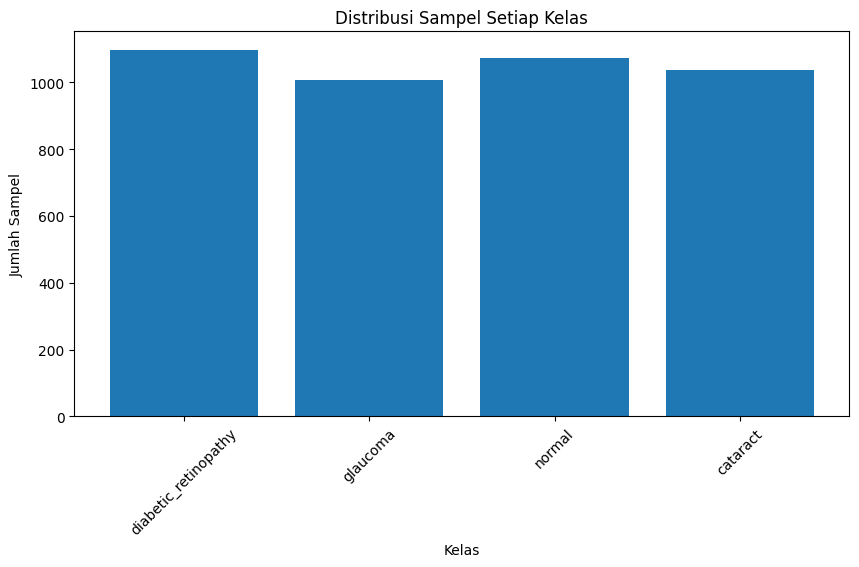

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Definisikan lokasi folder dataset
dataset_folder = "/content/eye-diseases-classification/dataset"

# Buat dictionary untuk menyimpan jumlah sampel setiap kelas
class_counts = {}

# Loop melalui setiap kelas
for class_name in os.listdir(dataset_folder):
    class_folder = os.path.join(dataset_folder, class_name)

    # Pastikan yang di-loop adalah folder, bukan file
    if os.path.isdir(class_folder):
        # Hitung jumlah gambar dalam setiap kelas
        num_images = len(os.listdir(class_folder))
        class_counts[class_name] = num_images

        # Tampilkan beberapa contoh gambar dari setiap kelas
        print(f"Class: {class_name} - Jumlah Sampel: {num_images}")
        print("-----------------------------------------------------")
        plt.figure(figsize=(10, 5))
        for i, image_file in enumerate(os.listdir(class_folder)[:3]):
            # Path lengkap menuju gambar
            image_path = os.path.join(class_folder, image_file)
            # Membaca dan menampilkan gambar menggunakan Matplotlib
            plt.subplot(1, 3, i + 1)
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.title(f"Sample {i + 1}")
            plt.axis('off')  # Menghilangkan sumbu
        plt.show()
        print("\n")

# Tampilkan distribusi sampel setiap kelas
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Distribusi Sampel Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
plt.show()


# **Split Model**

In [8]:
import os
import shutil
import random

# Direktori dataset
dataset_dir = "/content/eye-diseases-classification/dataset/"

# List tiap Class
classes = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]

# Ratio train, validation, dan test sets
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Loop tiap class class
for class_name in classes:
    # Path to the current class directory
    class_dir = os.path.join(dataset_dir, class_name)

    # List all files in the class directory
    files = os.listdir(class_dir)

    # acak secara random
    random.shuffle(files)

    # Menghitung jumlah file tiap set train test val
    num_files = len(files)
    num_train = int(num_files * train_ratio)
    num_val = int(num_files * val_ratio)
    num_test = num_files - num_train - num_val

    # Split files train, validation, dan test sets
    train_files = files[:num_train]
    val_files = files[num_train:num_train + num_val]
    test_files = files[num_train + num_val:]

    # Membuat direktori baru train, validation,dan test sets
    for folder_name, file_list in [("train", train_files), ("val", val_files), ("test", test_files)]:
        folder_path = os.path.join(dataset_dir, folder_name, class_name)
        os.makedirs(folder_path, exist_ok=True)
        # Pindah file ke tempat yang sesuai class
        for file in file_list:
            src = os.path.join(class_dir, file)
            dst = os.path.join(folder_path, file)
            shutil.move(src, dst)


# **Data Augmentation Dan Normalization **

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# Direktori dataset
dataset_dir = "/content/eye-diseases-classification/dataset/"

# Dimensi sebuah gambar
img_width, img_height = 256, 256

# ukuran Batch image
batch_size = 32

# Data augmentation dan normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    horizontal_flip=True)  # Randomly flips images horizontally

val_datagen = ImageDataGenerator(rescale=1./255)  #  normalization for validation set
test_datagen = ImageDataGenerator(rescale=1./255)  # normalization for test set

# Data generators
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'train'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'val'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_dir, 'test'),
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 3372 images belonging to 4 classes.
Found 419 images belonging to 4 classes.
Found 426 images belonging to 4 classes.


Model CNN 5 Layer

In [16]:
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Load pre-trained MobileNetV2 model without top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Output layer dengan 4 classes

# Compile the model with Adam optimizer
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test accuracy:', test_acc)


Epoch 1/50
105/105 [==============================] - 35s 294ms/step - loss: 2.3958 - accuracy: 0.6398 - val_loss: 0.5817 - val_accuracy: 0.8269
Epoch 2/50
105/105 [==============================] - 30s 283ms/step - loss: 0.6534 - accuracy: 0.7467 - val_loss: 0.6234 - val_accuracy: 0.8413
Epoch 3/50
105/105 [==============================] - 29s 279ms/step - loss: 0.6120 - accuracy: 0.7404 - val_loss: 0.5162 - val_accuracy: 0.8293
Epoch 4/50
105/105 [==============================] - 28s 272ms/step - loss: 0.5418 - accuracy: 0.7569 - val_loss: 0.4697 - val_accuracy: 0.8486
Epoch 5/50
105/105 [==============================] - 28s 264ms/step - loss: 0.4957 - accuracy: 0.7847 - val_loss: 0.3761 - val_accuracy: 0.8654
Epoch 6/50
105/105 [==============================] - 28s 267ms/step - loss: 0.4818 - accuracy: 0.7982 - val_loss: 0.4496 - val_accuracy: 0.8582
Epoch 7/50
105/105 [==============================] - 31s 293ms/step - loss: 0.4464 - accuracy: 0.8042 - val_loss: 0.3865 - val_ac

# **Visualisasi Evaluasi Accuracy Model**

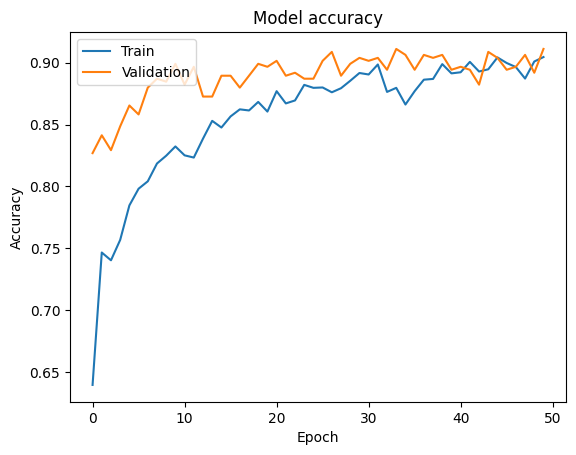

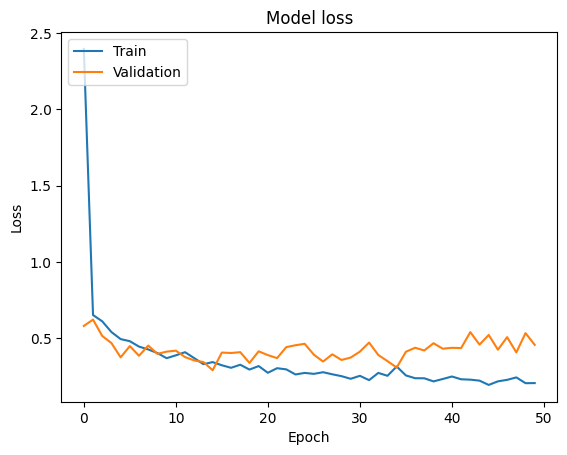

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Evaluasi Mode Confusion Matrix, Precission, recall, dan F1-Score**

14/14 [==============================] - 6s 357ms/step


<Figure size 800x800 with 0 Axes>

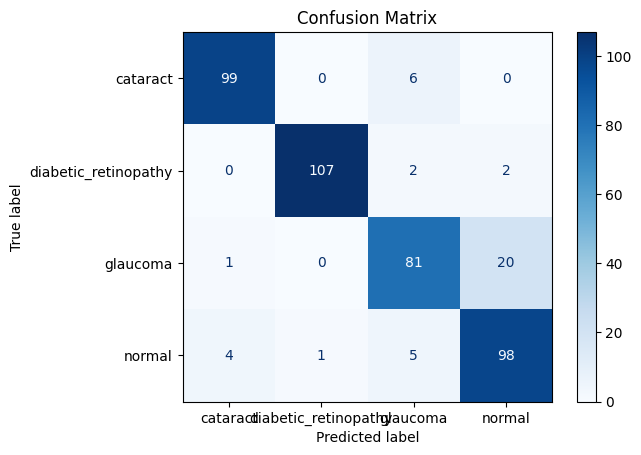

                      precision    recall  f1-score   support

            cataract       0.95      0.94      0.95       105
diabetic_retinopathy       0.99      0.96      0.98       111
            glaucoma       0.86      0.79      0.83       102
              normal       0.82      0.91      0.86       108

            accuracy                           0.90       426
           macro avg       0.91      0.90      0.90       426
        weighted avg       0.91      0.90      0.90       426



In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ambil prediksi kelas dari model pada dataset uji
y_pred = np.argmax(model.predict(test_generator), axis=1)

# Ambil label sebenarnya dari dataset uji
y_true = test_generator.classes

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Definisikan kelas label (misalnya: cataract, diabetic_retinopathy, glaucoma, normal)
classes = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# Tampilkan confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Hitung dan tampilkan classification report (precision, recall, F1-score)
report = classification_report(y_true, y_pred, target_names=classes)
print(report)
